<a href="https://colab.research.google.com/github/MRaynardAlif/HVAC-Anomaly-Detection-Model/blob/main/AnomalyDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


lr: 9.999999747378752e-05
Epoch 1/200
159/159 [==============================] - 11s 40ms/step - loss: 0.7546 - val_loss: 0.2631
lr: 9.999999747378752e-05
Epoch 2/200
159/159 [==============================] - 6s 37ms/step - loss: 0.4123 - val_loss: 0.1710
lr: 9.999999747378752e-05
Epoch 3/200
159/159 [==============================] - 5s 33ms/step - loss: 0.3008 - val_loss: 0.1567
lr: 9.999999747378752e-05
Epoch 4/200
159/159 [==============================] - 7s 42ms/step - loss: 0.2613 - val_loss: 0.1710
lr: 9.999999747378752e-05
Epoch 5/200
159/159 [==============================] - 5s 33ms/step - loss: 0.2377 - val_loss: 0.1625
lr: 9.999999747378752e-05
Epoch 6/200
159/159 [==============================] - 7s 41ms/step - loss: 0.2150 - val_loss: 0.1476
lr: 9.999999747378752e-05
Epoch 7/200
159/159 [==============================] - 5s 33ms/step - loss: 0.1952 - val_loss: 0.1399
lr: 9.999999747378752e-05
Epoch 8/200
159/159 [==============================] - 6s 35ms/step - loss: 0

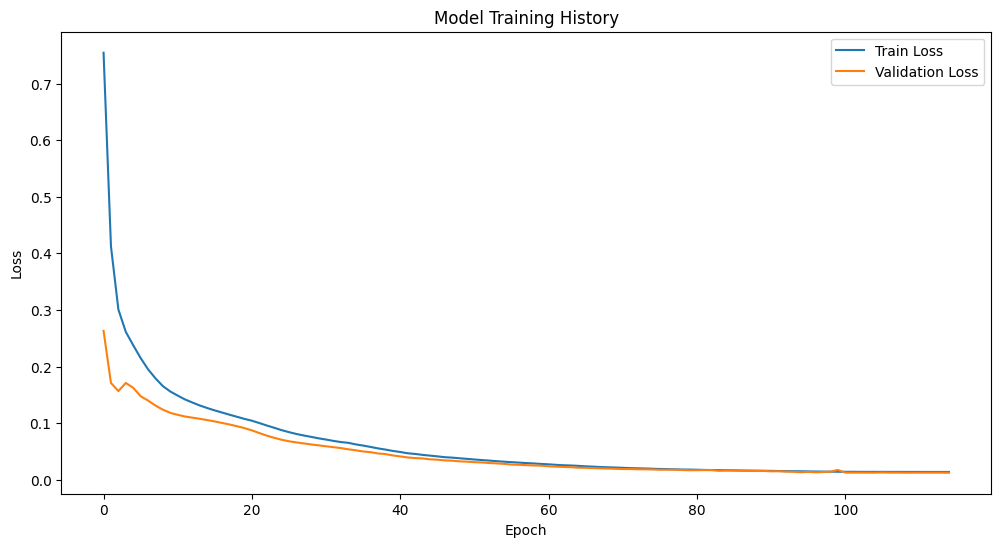

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, History
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Function to scale data using Min-Max scaling
def scale_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/HVAC_DATASET/HVAC_NE_EC_19-21.csv')

# Extract features
features = data[['T_Supply', 'T_Return', 'SP_Return', 'T_Saturation', 'T_Outdoor', 'RH_Supply', 'RH_Return', 'RH_Outdoor', 'Energy', 'Power']]

# Normalize features and target variables using Min-Max scaling
scaled_features, scaler = scale_data(features)

# Add an additional dimension to scaled_features
scaled_features = np.expand_dims(scaled_features, axis=2)

# Reshape data for LSTM
reshaped_features = scaled_features

# Define autoencoder model using functional API
input_layer = Input(shape=(scaled_features.shape[1], scaled_features.shape[2]))

# Encoder
encoded = LSTM(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

# Decoder
decoded = RepeatVector(scaled_features.shape[1])(encoded)
decoded = LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.0001))(decoded)
decoded = Dropout(0.3)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = LSTM(scaled_features.shape[2], activation='linear', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.0001))(decoded)

# Create autoencoder model
autoencoder = Model(input_layer, decoded)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, history):
        super(CustomLRScheduler, self).__init__()
        self.history = history

    def on_epoch_end(self, epoch, logs=None):
        loss = self.history.history['loss'][-1]
        val_loss = self.history.history['val_loss'][-1]
        if loss <= val_loss:
            lr = self.model.optimizer.lr * 0.1
            self.model.optimizer.lr.assign(lr)

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy()
        print(f'lr: {lr}')


# Train the autoencoder
history = autoencoder.fit(reshaped_features, reshaped_features, epochs=200, batch_size=128, validation_split=0.4,
                          callbacks=[history:=tf.keras.callbacks.History(),
                                     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                                    CustomLRScheduler(history=history), PrintLR()])

# Evaluate the autoencoder on the training set
decoded_data = autoencoder.predict(reshaped_features)

# Add an additional dimension to decoded_data
decoded_data = np.expand_dims(decoded_data, axis=2)

# Calculate mean squared error
mse = np.mean(np.square(reshaped_features - decoded_data[:, :, 0]), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 99)  # Adjust percentile based on your dataset

# Identify anomalies
upper_anomalies = scaled_features[np.squeeze(mse > threshold)]
lower_anomalies = scaled_features[np.squeeze(mse < threshold)]

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function to plot training history
plot_training_history(history)


        T_Supply   T_Return  SP_Return  T_Saturation  T_Outdoor  RH_Supply  \
0      19.859999  20.469999       18.5     19.020000  20.299999  71.110001   
1      19.855000  20.430000       18.5     19.020000  20.299999  71.320000   
2      19.850000  20.410000       18.5     19.020000  20.299999  71.470001   
3      19.840000  20.379999       18.5     19.080000  20.299999  71.439995   
4      19.830000  20.350000       18.5     19.080000  20.299999  71.580002   
...          ...        ...        ...           ...        ...        ...   
33883  19.539999  20.004999       20.5     19.619999  14.700000  39.020000   
33884  19.520000  19.949999       20.5     19.539999  13.700000  39.020000   
33885  19.430000  19.955000       20.5     19.420000  13.700000  39.399998   
33886  19.420000  19.920000       20.5     19.400000  13.700000  39.599998   
33887  19.420000  19.900000       20.5     19.400000  13.700000  39.599998   

       RH_Return  RH_Outdoor  Energy  Power  
0      58.919998 

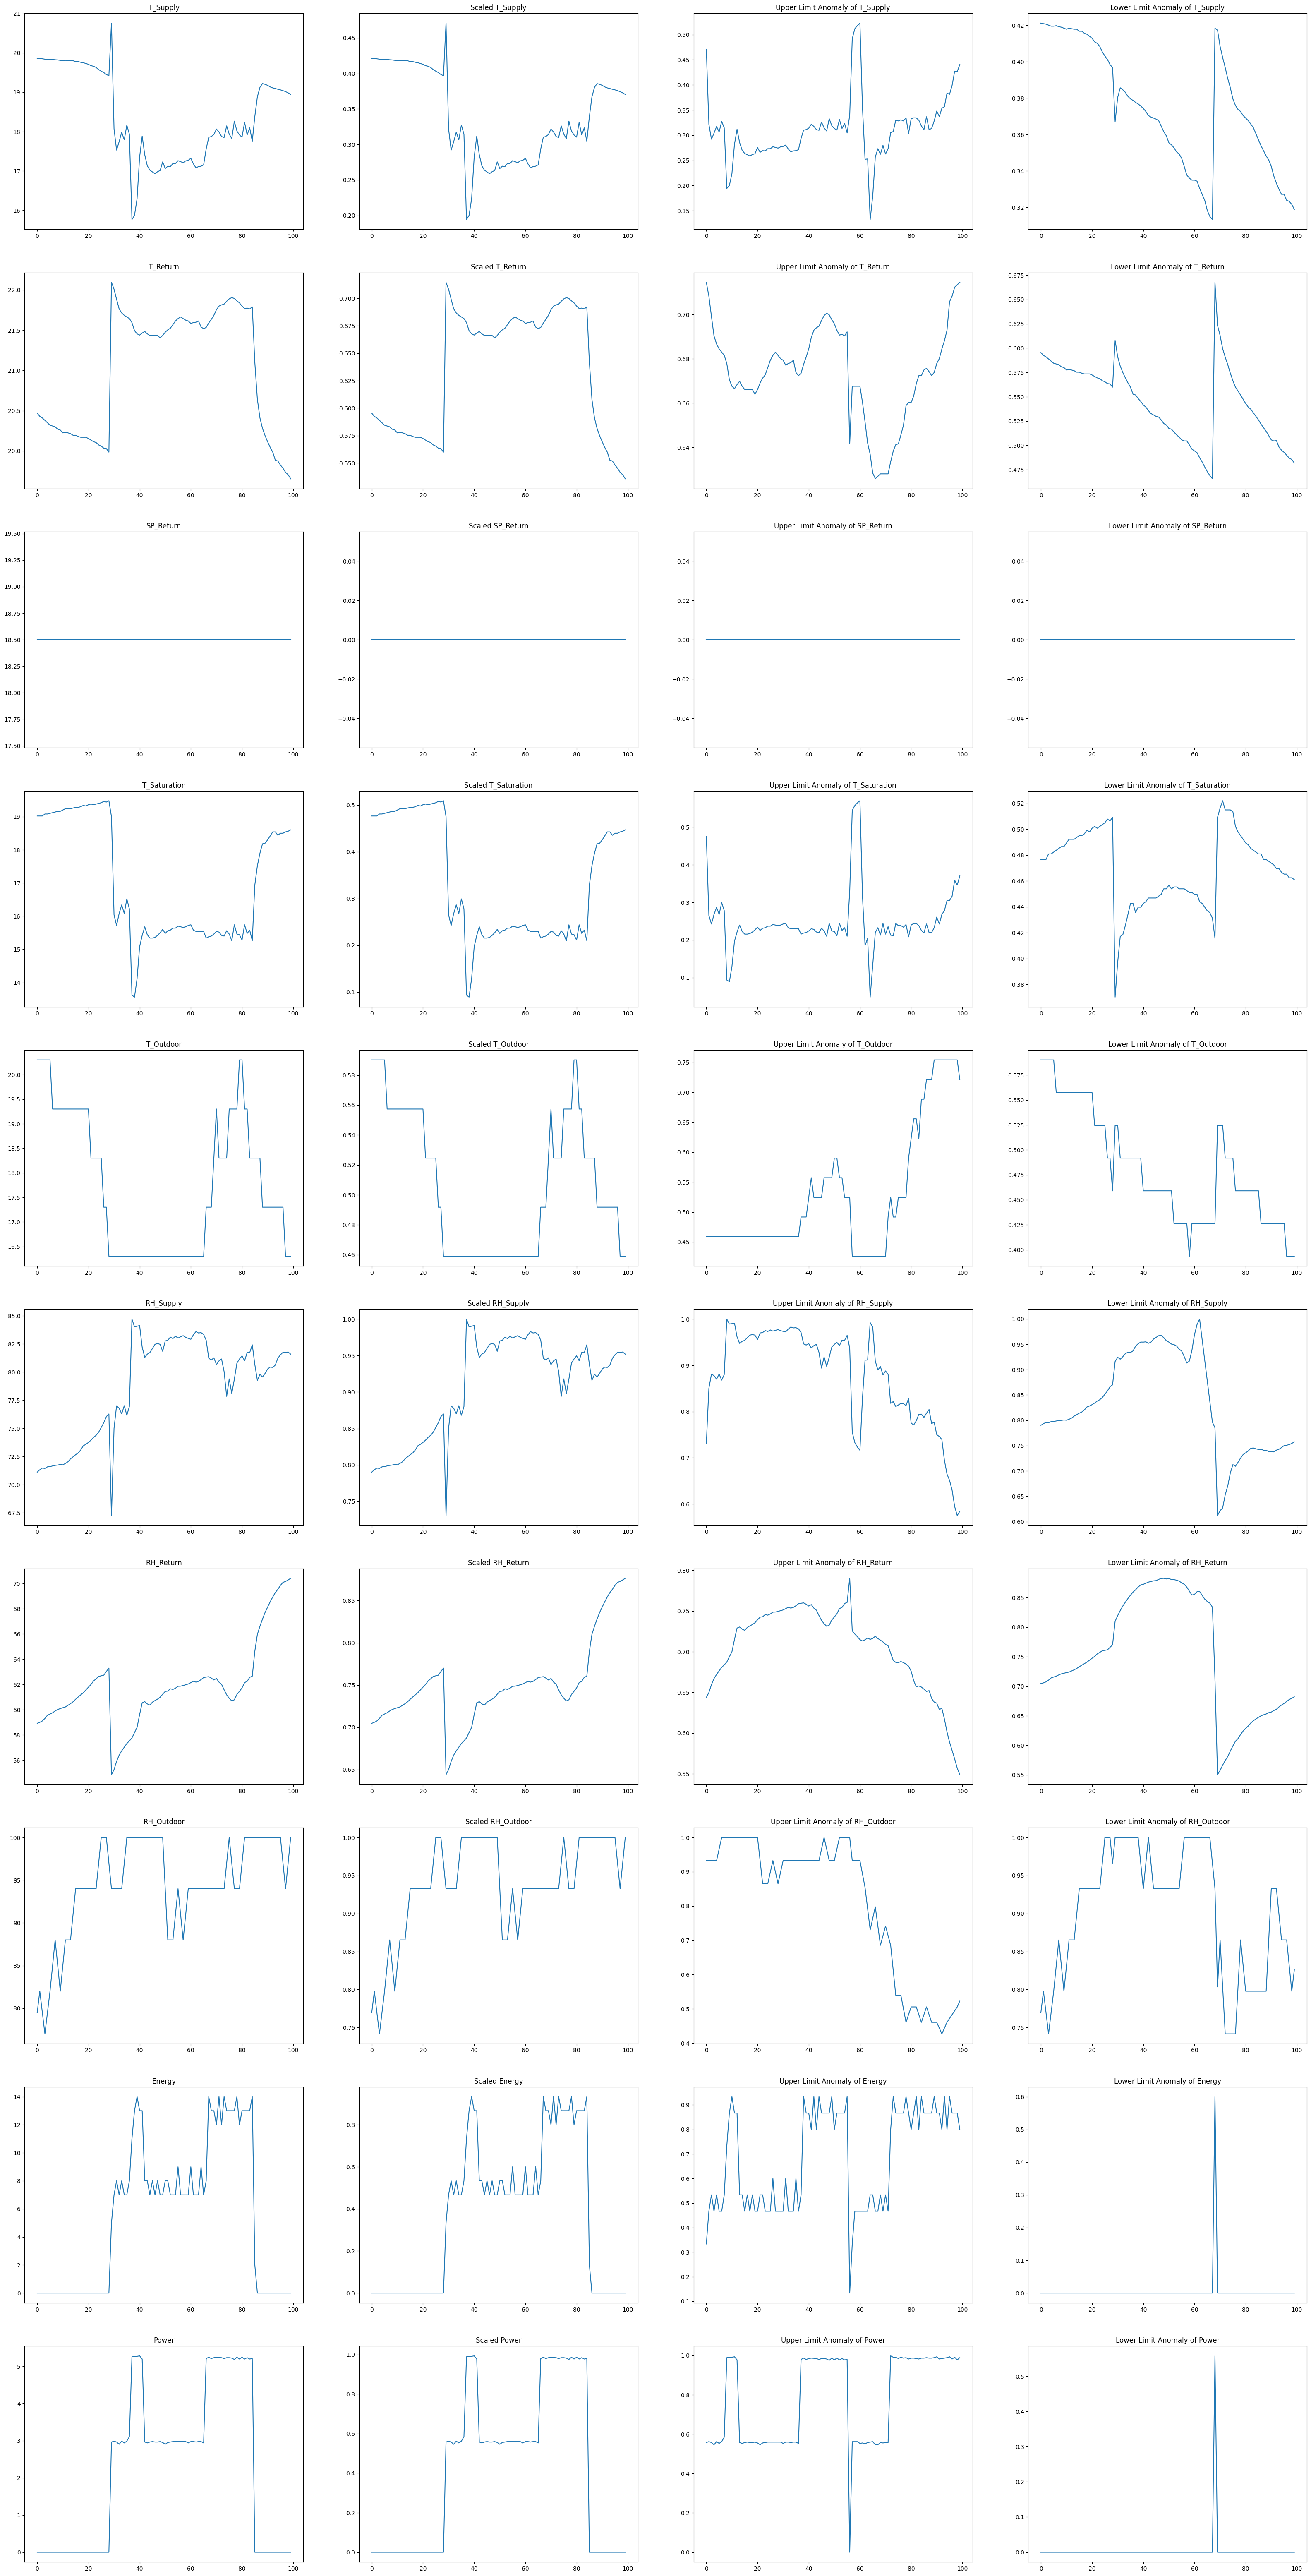

In [ ]:
print(features)
print(scaled_features)

# Plot the anomalies
num_features = features.shape[1]
fig, axs = plt.subplots(num_features, 4, figsize=(40, 8*num_features))

# Loop through each feature
for i in range(num_features):
    # Plot the original feature in the first subplot
    axs[i, 0].plot(features.iloc[:100, i], label=features.columns[i])
    axs[i, 0].set_title(f'{features.columns[i]}')

    # Plot the scaled feature in the second subplot
    axs[i, 1].plot(scaled_features[:100, i], label=features.columns[i])
    axs[i, 1].set_title(f'Scaled {features.columns[i]}')

    # Plot the upper anomalies of the feature in the third subplot
    axs[i, 2].plot(upper_anomalies[:100, i], label=features.columns[i])
    axs[i, 2].set_title(f'Upper Limit Anomaly of {features.columns[i]}')

    # Plot the upper anomalies of the feature in the third subplot
    axs[i, 3].plot(lower_anomalies[:100, i], label=features.columns[i])
    axs[i, 3].set_title(f'Lower Limit Anomaly of {features.columns[i]}')

# Show the figure
plt.show()

In [ ]:
import os

# Define the path where you want to save the model
model_path = os.path.join('/content/drive/MyDrive/HVAC_DATASET/HVACAnomalyDetectionModel.h5')

# Save the model to the specified path
autoencoder.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Model Link:
##https://drive.google.com/file/d/1g_YITmzWiZRizNsU4Yj_ggv_7fD4q1gc/view?usp=sharing

##Dataset Link:
##https://drive.google.com/file/d/10MioKSnZUDRjHkhiPk49DN-WliIhyKYY/view?usp=sharing


#The dataset refers to the operating parameters of an HVAC system that controls the environmental comfort of a non-residential building located in Turin (Italy).

###The dataset contains 11 variables:

###timestamp;
###temperatures of return, supply, and outdoor air [°C];
###relative humidities of return, supply and outdoor air [% and outdoor air [%];
###the temperature setpoint of the return air [°C];
###the saturation temperature in the humidifier [°C];
###power required by the fans [kW];
###energy required by the fans [kWh].

Assuming the dataset containing data of HVAC normal activity, and the model made to detect the anomalies when the activity is higher or lower than the normal activity.
